<a href="https://colab.research.google.com/github/SimreAniri/Neural-Networks/blob/master/Lesson_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
import numpy as np
from PIL import Image

from tensorflow.keras.utils import plot_model


# метрика на Tensorflow

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


geyer2020a2d2,

A2D2: Audi Autonomous Driving Dataset

Якоб Гейер и Йоханнес Кассахун, Ментар Махмуди, Ксавьер Рику, Рупеш Дургеш, Эндрю С. Чанг, Лоренц Хаусвальд, Вьет Хоанг Фам и Максимилиан М Хлегг, Себастьян Дорн, Тиффани Фернандес и Мартин Дж нике и Судеш Мираши, Чирагкумар Савани, Мартин Штурм, Александр Воробьев, Мартин Элькер, Себастьян Гаррейс и Питер Шуберт,

2020,

https://www.a2d2.audi


In [3]:
PAHT_image = '/gdrive/My Drive/Data Science/camera_lidar_semantic/img/'
PAHT_label = '/gdrive/My Drive/Data Science/camera_lidar_semantic/label/'

In [4]:
import os, fnmatch
imag = os.listdir(PAHT_image)
imag_label = os.listdir(PAHT_label)

In [5]:
imag,imag_label

(['1.png',
  '2.png',
  '4.png',
  '3.png',
  '7.png',
  '5.png',
  '6.png',
  '10.png',
  '8.png',
  '9.png'],
 ['1.png',
  '2.png',
  '4.png',
  '3.png',
  '7.png',
  '5.png',
  '6.png',
  '9.png',
  '10.png',
  '8.png'])

In [6]:
images = []
segments = []
image_size = (600,800)
for i_name in imag:
  images.append(image.load_img(PAHT_image+i_name ,target_size=image_size))
  segments.append(image.load_img(PAHT_label+i_name, target_size=image_size))

Входной кадр и разметка:

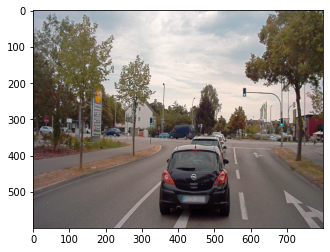

In [7]:
plt.imshow(images[0].convert('RGBA'))
plt.show()

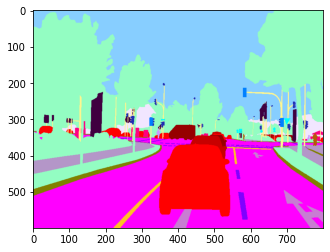

In [8]:
plt.imshow(segments[0].convert('RGBA'))
plt.show()

Собираем входные примеры:

In [9]:
xTrain_Test = []

for img in images:
  x = image.img_to_array(img)
  xTrain_Test.append(x)

xTrain_Test = np.array(xTrain_Test)

In [10]:
print(xTrain_Test.shape)

(10, 600, 800, 3)


Описание разметки:

In [11]:
class_list = {
              "ff 00 00": "Car 1",
              "c8 00 00": "Car 2",
              "96 00 00": "Car 3",
              "80 00 00": "Car 4",
              "b6 59 06": "Bicycle 1",
              "96 32 04": "Bicycle 2",
              "5a 1e 01": "Bicycle 3",
              "5a 1e 1e": "Bicycle 4",
              "cc 99 ff": "Pedestrian 1",
              "bd 49 9b": "Pedestrian 2",
              "ef 59 bf": "Pedestrian 3",
              "ff 80 00": "Truck 1",
              "c8 80 00": "Truck 2",
              "96 80 00": "Truck 3",
              "00 ff 00": "Small vehicles 1",
              "00 c8 00": "Small vehicles 2",
              "00 96 00": "Small vehicles 3",
              "00 80 ff": "Traffic signal 1",
              "1e 1c 9e": "Traffic signal 2",
              "3c 1c 64": "Traffic signal 3",
              "00 ff ff": "Traffic sign 1",
              "1e dc dc": "Traffic sign 2",
              "3c 9d c7": "Traffic sign 3",
              "ff ff 00": "Utility vehicle 1",
              "ff ff c8": "Utility vehicle 2",
              "e9 64 00": "Sidebars",
              "6e 6e 00": "Speed bumper",
              "80 80 00": "Curbstone",
              "ff c1 25": "Solid line",
              "40 00 40": "Irrelevant signs",
              "b9 7a 57": "Road blocks",
              "00 00 64": "Tractor",
              "8b 63 6c": "Non-drivable street",
              "d2 32 73": "Zebra crossing",
              "ff 00 80": "Obstacles / trash",
              "ff f6 8f": "Poles",
              "96 00 96": "RD restricted area",
              "cc ff 99": "Animals",
              "ee a2 ad": "Grid structure",
              "21 2c b1": "Signal corpus",
              "b4 32 b4": "Drivable cobblestone",
              "ff 46 b9": "Electronic traffic",
              "ee e9 bf": "Slow drive area",
              "93 fd c2": "Nature object",
              "96 96 c8": "Parking area",
              "b4 96 c8": "Sidewalk",
              "48 d1 cc": "Ego car",
              "c8 7d d2": "Painted driv. instr.",
              "9f 79 ee": "Traffic guide obj.",
              "80 00 ff": "Dashed line",
              "ff 00 ff": "RD normal street",
              "87 ce ff": "Sky",
              "f1 e6 ff": "Buildings",
              "60 45 8f": "Blurred area",
              "35 2e 52": "Rain dirt"
}

In [12]:
arr_col = []

for key in class_list.keys():
  arr_col.append([int(i, 16) for i in key.split()])

arr_col

[[255, 0, 0],
 [200, 0, 0],
 [150, 0, 0],
 [128, 0, 0],
 [182, 89, 6],
 [150, 50, 4],
 [90, 30, 1],
 [90, 30, 30],
 [204, 153, 255],
 [189, 73, 155],
 [239, 89, 191],
 [255, 128, 0],
 [200, 128, 0],
 [150, 128, 0],
 [0, 255, 0],
 [0, 200, 0],
 [0, 150, 0],
 [0, 128, 255],
 [30, 28, 158],
 [60, 28, 100],
 [0, 255, 255],
 [30, 220, 220],
 [60, 157, 199],
 [255, 255, 0],
 [255, 255, 200],
 [233, 100, 0],
 [110, 110, 0],
 [128, 128, 0],
 [255, 193, 37],
 [64, 0, 64],
 [185, 122, 87],
 [0, 0, 100],
 [139, 99, 108],
 [210, 50, 115],
 [255, 0, 128],
 [255, 246, 143],
 [150, 0, 150],
 [204, 255, 153],
 [238, 162, 173],
 [33, 44, 177],
 [180, 50, 180],
 [255, 70, 185],
 [238, 233, 191],
 [147, 253, 194],
 [150, 150, 200],
 [180, 150, 200],
 [72, 209, 204],
 [200, 125, 210],
 [159, 121, 238],
 [128, 0, 255],
 [255, 0, 255],
 [135, 206, 255],
 [241, 230, 255],
 [96, 69, 143],
 [53, 46, 82]]

Делаем конвертер в one-hot_encoding для выходных примеров

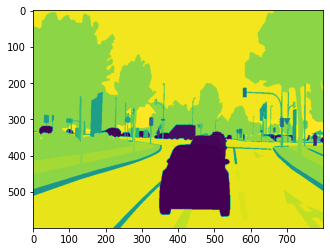

In [13]:
def Color2index(y):
  y_ind = np.zeros((y.shape[0],y.shape[1]))
  y_cat = np.zeros((y.shape[0],y.shape[1], len(arr_col)))
  i = 1
  for i_color in arr_col:
    ind_i = np.where((y[:,:,0]==i_color[0])&(y[:,:,1]==i_color[1])&(y[:,:,2]==i_color[2]))
    y_ind[ind_i[0],ind_i[1]] = i
    y_cat[ind_i[0],ind_i[1], i-1] = 1 
    i += 1
  
  return y_cat, y_ind, i-1
cat_yi,ind_yi,h = Color2index(image.img_to_array(segments[0]))
plt.imshow(ind_yi.astype(float)/h)
plt.show() 

In [14]:
cat_yi.shape

(600, 800, 55)

Сегментированную картинку в One hot encoding (разметка на 55 классов)

In [15]:
yTrain_Test = []

for seg in segments:
  y_cat,_,_ = Color2index(image.img_to_array(seg))
  yTrain_Test.append(y_cat)

yTrain_Test = np.array(yTrain_Test)

In [16]:
print(yTrain_Test.shape)

(10, 600, 800, 55)


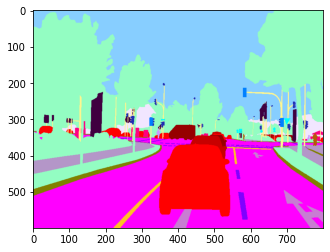

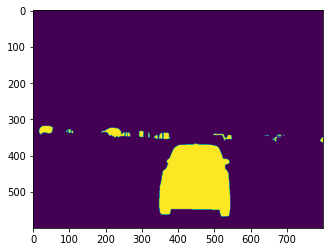

In [17]:
n = 0
plt.imshow(segments[n].convert('RGBA'))
plt.show()
img = yTrain_Test[n][:,:,0]
plt.imshow(img.astype(float))
plt.show()

Делим на тест и трейн по числу N

In [18]:
N = 8
yTrain = yTrain_Test[:N,:,:,:]
xTrain = xTrain_Test[:N,:,:,:]

yTest = yTrain_Test[N:,:,:,:]
xTest = xTrain_Test[N:,:,:,:]

In [19]:
yTest.shape

(2, 600, 800, 55)

In [20]:
print(xTrain.shape)
print(yTrain.shape)

(8, 600, 800, 3)
(8, 600, 800, 55)


Создаём и обучаем U-net

In [21]:
def cuttedUnet(num_classes = 55, input_shape= (600, 800, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    #x = MaxPooling2D()(block_4_out)

    # Block 5
    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)


    # Load pretrained weights.
    #for_pretrained_weight = MaxPooling2D()(x)
    #vgg16 = Model(img_input, for_pretrained_weight)
    #vgg16.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

    # UP 1
    #x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = concatenate([x, block_4_out])
    #x = Conv2D(512, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 600, 800, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 600, 800, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 600, 800, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 600, 800, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

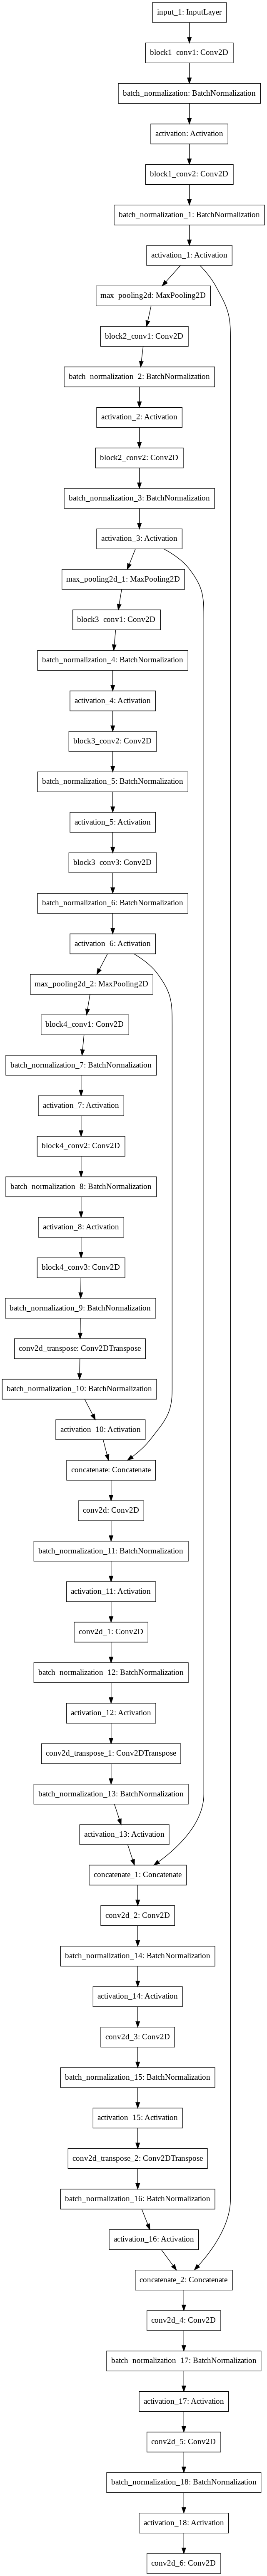

In [22]:
modelC = cuttedUnet(55, (600, 800, 3))

plot_model(modelC, to_file='modelC.png')

In [51]:
history = modelC.fit(xTrain, yTrain, epochs=10, batch_size=1, validation_data=(xTrain, yTrain))

Epoch 1/10
8/8 [==============================] - 14s 2s/step - loss: 0.2302 - dice_coef: 0.8936 - val_loss: 1.2103 - val_dice_coef: 0.6921
Epoch 2/10
8/8 [==============================] - 13s 2s/step - loss: 0.2248 - dice_coef: 0.8948 - val_loss: 0.9717 - val_dice_coef: 0.7169
Epoch 3/10
8/8 [==============================] - 13s 2s/step - loss: 0.2331 - dice_coef: 0.8936 - val_loss: 1.2693 - val_dice_coef: 0.6306
Epoch 4/10
8/8 [==============================] - 13s 2s/step - loss: 0.2089 - dice_coef: 0.9021 - val_loss: 1.3297 - val_dice_coef: 0.6761
Epoch 5/10
8/8 [==============================] - 13s 2s/step - loss: 0.1876 - dice_coef: 0.9106 - val_loss: 0.8739 - val_dice_coef: 0.7348
Epoch 6/10
8/8 [==============================] - 13s 2s/step - loss: 0.1809 - dice_coef: 0.9120 - val_loss: 0.9398 - val_dice_coef: 0.7018
Epoch 7/10
8/8 [==============================] - 13s 2s/step - loss: 0.1780 - dice_coef: 0.9160 - val_loss: 0.8100 - val_dice_coef: 0.7480
Epoch 8/10
8/8 [====

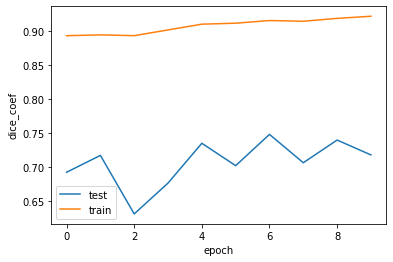

In [52]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

In [53]:
pred = modelC.predict(xTest)
print(pred.shape)

(2, 600, 800, 55)


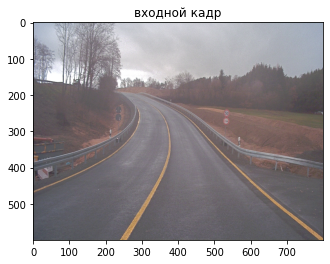

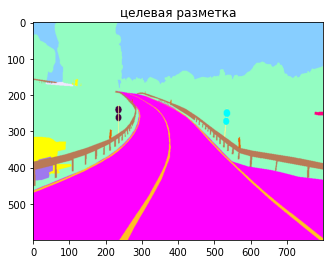

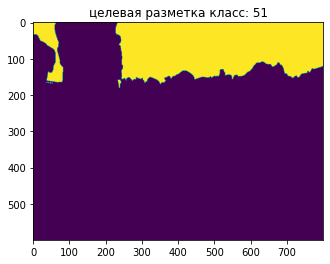

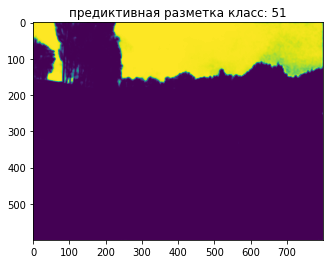

In [54]:
n = 1
class_ = 51
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = pred[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()

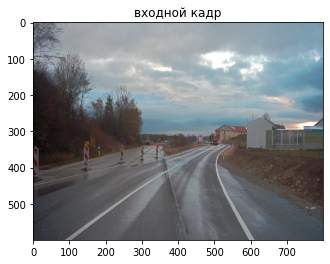

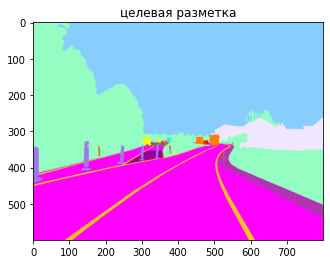

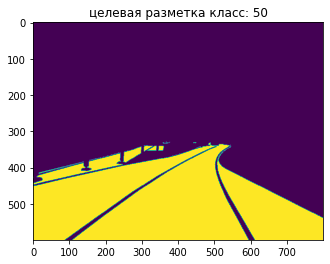

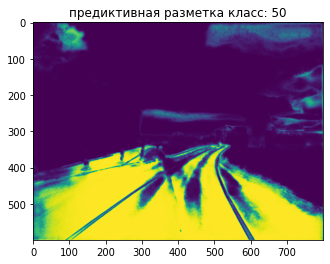

In [55]:
n = 0
class_ = 50
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = pred[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()

Претренированная Unet

In [56]:
 pre_trained_model = VGG16(input_shape=xTest.shape[1:], include_top=False, weights="imagenet")

In [57]:
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 600, 800, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 600, 800, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 600, 800, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 300, 400, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 300, 400, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 300, 400, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 150, 200, 128)     0     

In [58]:
def unet_pre_train(num_classes = 55, input_shape= (600, 800, 3)):    
    pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

    for layer in pre_trained_model.layers[:18]:
      layer.trainable = False
    x = pre_trained_model.layers[13].output
    block_4_out = pre_trained_model.layers[10].output
    block_3_out = pre_trained_model.layers[6].output
    block_2_out = pre_trained_model.layers[3].output
    img_input = pre_trained_model.inputs
    print(block_4_out)
    print(block_3_out)
    print(block_2_out)
    # UP 1

    # добавили перенос из понижаюшего плеча VGG16
    x = concatenate([x, block_4_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча VGG16
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча VGG16
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

KerasTensor(type_spec=TensorSpec(shape=(None, 75, 100, 256), dtype=tf.float32, name=None), name='block3_pool/MaxPool:0', description="created by layer 'block3_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 150, 200, 128), dtype=tf.float32, name=None), name='block2_pool/MaxPool:0', description="created by layer 'block2_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 300, 400, 64), dtype=tf.float32, name=None), name='block1_pool/MaxPool:0', description="created by layer 'block1_pool'")
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 600, 800, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 600, 800, 64) 1792        input_4[0][0]       

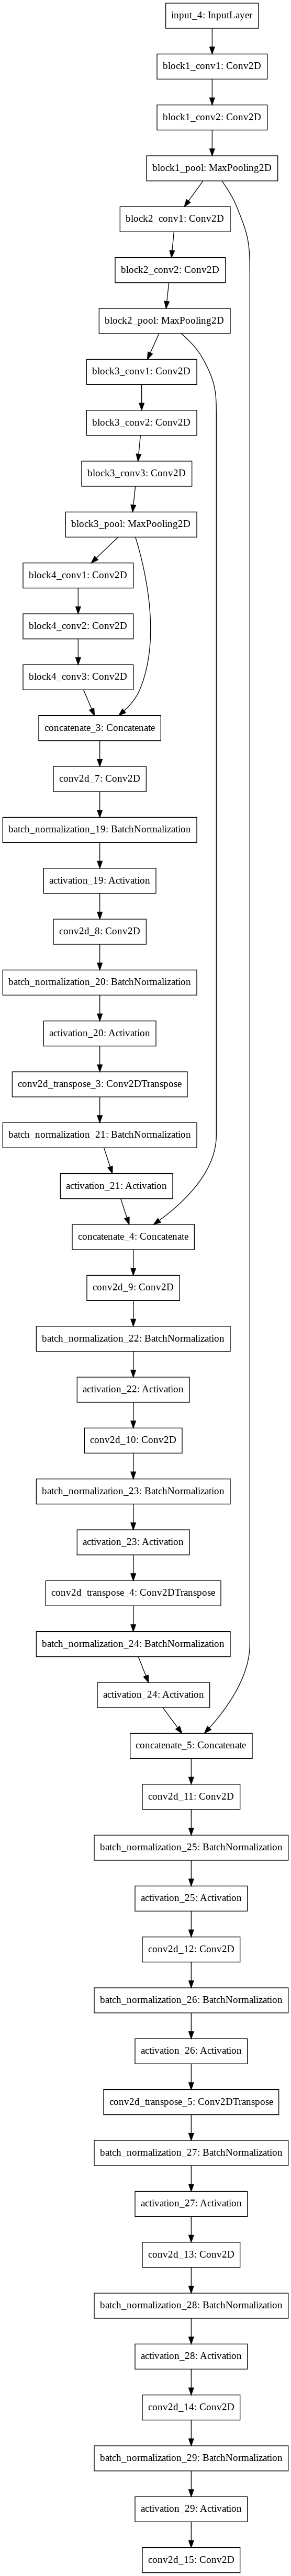

In [59]:
modelU = unet_pre_train(num_classes = 55, input_shape= (600, 800, 3))

plot_model(modelU, to_file='modelU.png')

In [60]:
history = modelU.fit(xTrain, yTrain, epochs=60, batch_size=3, validation_data=(xTrain, yTrain))

Epoch 1/60
3/3 [==============================] - 45s 10s/step - loss: 3.9472 - dice_coef: 0.0321 - val_loss: 2.8309 - val_dice_coef: 0.2494
Epoch 2/60
3/3 [==============================] - 10s 4s/step - loss: 2.1049 - dice_coef: 0.2399 - val_loss: 4.3053 - val_dice_coef: 0.3018
Epoch 3/60
3/3 [==============================] - 10s 4s/step - loss: 1.4143 - dice_coef: 0.4824 - val_loss: 7.0260 - val_dice_coef: 0.3008
Epoch 4/60
3/3 [==============================] - 10s 4s/step - loss: 1.2071 - dice_coef: 0.5675 - val_loss: 10.3832 - val_dice_coef: 0.2926
Epoch 5/60
3/3 [==============================] - 10s 4s/step - loss: 1.0368 - dice_coef: 0.6041 - val_loss: 11.7673 - val_dice_coef: 0.2782
Epoch 6/60
3/3 [==============================] - 10s 4s/step - loss: 1.1147 - dice_coef: 0.5898 - val_loss: 9.4469 - val_dice_coef: 0.2957
Epoch 7/60
3/3 [==============================] - 10s 4s/step - loss: 0.9661 - dice_coef: 0.6285 - val_loss: 6.2326 - val_dice_coef: 0.3307
Epoch 8/60
3/3 [=

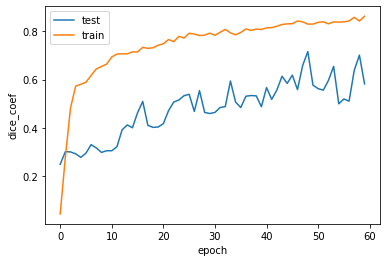

In [61]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

In [62]:
predu = modelU.predict(xTest)
print(pred.shape)

(2, 600, 800, 55)


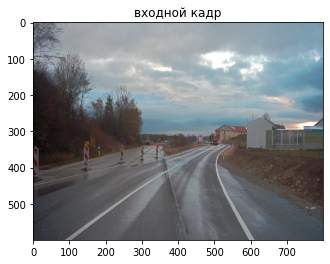

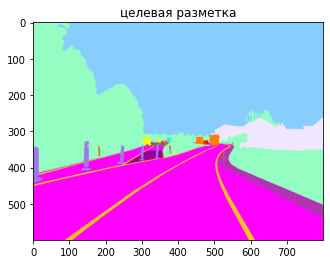

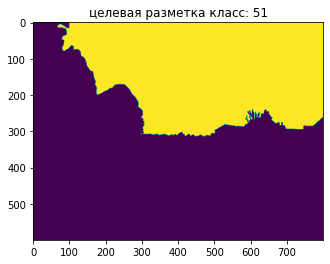

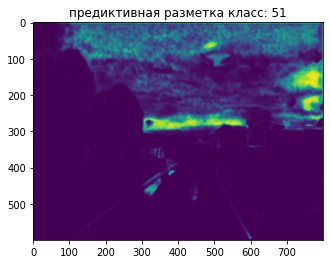

In [63]:
n = 0
class_ = 51
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = predu[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()

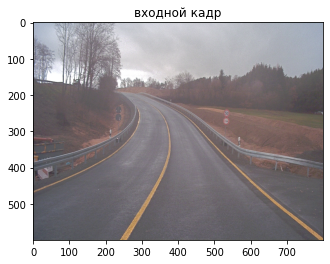

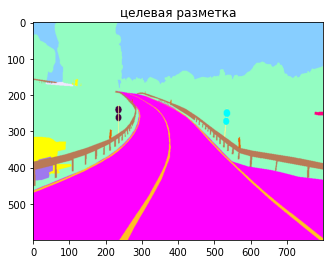

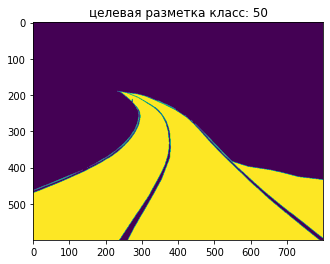

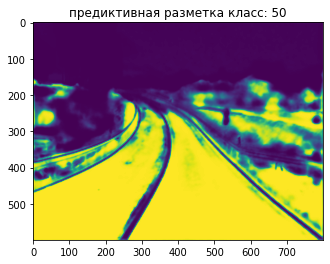

In [64]:
n = 1
class_ = 50
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = predu[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()